# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Keshav Singh"
student2 = "Milena Filipovic" 

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import History 
from keras import regularizers
import seaborn as sns

Using TensorFlow backend.


### Plotting

In [3]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [4]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

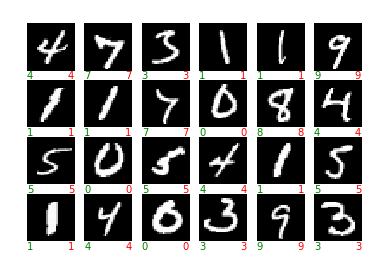

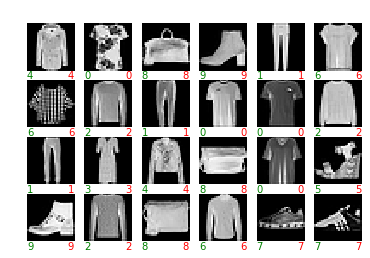

In [5]:
x_train.shape
plot_some_samples(x_train.reshape(-1,28*28),y_train,y_train)
plot_some_samples(x_fashion_train.reshape(-1,28*28),y_fashion_train,y_fashion_train)
np.unique(y_fashion_train)


Answer to question 2:

The green digits represent the y class label for every number in the sample set supplied (X). The red digits represent the predicted y class label for every number in the sample set supplied

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [6]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [7]:
print(np.max(x_train))
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

255


## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

Train on 54000 samples, validate on 6000 samples
Epoch 1/200
54000/54000 [==============================] - 7s 126us/step - loss: 1.3392 - acc: 0.6764 - val_loss: 0.8115 - val_acc: 0.8527
Epoch 2/200
54000/54000 [==============================] - ETA: 0s - loss: 0.7575 - acc: 0.830 - 1s 27us/step - loss: 0.7568 - acc: 0.8304 - val_loss: 0.5837 - val_acc: 0.8838
Epoch 3/200
54000/54000 [==============================] - 1s 27us/step - loss: 0.6168 - acc: 0.8527 - val_loss: 0.4946 - val_acc: 0.8927
Epoch 4/200
54000/54000 [==============================] - 1s 28us/step - loss: 0.5498 - acc: 0.8637 - val_loss: 0.4451 - val_acc: 0.8983
Epoch 5/200
54000/54000 [==============================] - 1s 26us/step - loss: 0.5091 - acc: 0.8706 - val_loss: 0.4139 - val_acc: 0.9007
Epoch 6/200
54000/54000 [==============================] - 2s 28us/step - loss: 0.4812 - acc: 0.8759 - val_loss: 0.3920 - val_acc: 0.9037
Epoch 7/200
54000/54000 [==============================] - 1s 27us/step - loss: 0.46

Epoch 118/200
54000/54000 [==============================] - 2s 33us/step - loss: 0.2896 - acc: 0.9195 - val_loss: 0.2445 - val_acc: 0.9345
Epoch 119/200
54000/54000 [==============================] - 1s 23us/step - loss: 0.2894 - acc: 0.9194 - val_loss: 0.2443 - val_acc: 0.9338
Epoch 120/200
54000/54000 [==============================] - 1s 23us/step - loss: 0.2892 - acc: 0.9196 - val_loss: 0.2442 - val_acc: 0.9345
Epoch 121/200
54000/54000 [==============================] - 1s 25us/step - loss: 0.2890 - acc: 0.9196 - val_loss: 0.2440 - val_acc: 0.9347
Epoch 122/200
54000/54000 [==============================] - 1s 26us/step - loss: 0.2887 - acc: 0.9198 - val_loss: 0.2438 - val_acc: 0.9340
Epoch 123/200
54000/54000 [==============================] - 1s 26us/step - loss: 0.2885 - acc: 0.9196 - val_loss: 0.2438 - val_acc: 0.9345
Epoch 124/200
54000/54000 [==============================] - 1s 25us/step - loss: 0.2883 - acc: 0.9198 - val_loss: 0.2436 - val_acc: 0.9343
Epoch 125/200
54000/

54000/54000 [==============================] - 2s 33us/step - loss: 0.4647 - acc: 0.8446 - val_loss: 0.4631 - val_acc: 0.8418
Epoch 35/200
54000/54000 [==============================] - 2s 32us/step - loss: 0.4634 - acc: 0.8443 - val_loss: 0.4615 - val_acc: 0.8402
Epoch 36/200
54000/54000 [==============================] - 2s 31us/step - loss: 0.4618 - acc: 0.8454 - val_loss: 0.4612 - val_acc: 0.8413
Epoch 37/200
54000/54000 [==============================] - 2s 35us/step - loss: 0.4604 - acc: 0.8456 - val_loss: 0.4580 - val_acc: 0.8425
Epoch 38/200
54000/54000 [==============================] - 2s 31us/step - loss: 0.4589 - acc: 0.8457 - val_loss: 0.4567 - val_acc: 0.8400
Epoch 39/200
54000/54000 [==============================] - 2s 30us/step - loss: 0.4576 - acc: 0.8464 - val_loss: 0.4551 - val_acc: 0.8417
Epoch 40/200
54000/54000 [==============================] - 1s 25us/step - loss: 0.4564 - acc: 0.8467 - val_loss: 0.4546 - val_acc: 0.8422
Epoch 41/200
54000/54000 [==============

54000/54000 [==============================] - 1s 27us/step - loss: 0.4211 - acc: 0.8566 - val_loss: 0.4262 - val_acc: 0.8520
Epoch 94/200
54000/54000 [==============================] - 1s 26us/step - loss: 0.4207 - acc: 0.8562 - val_loss: 0.4246 - val_acc: 0.8518
Epoch 95/200
54000/54000 [==============================] - 1s 27us/step - loss: 0.4203 - acc: 0.8575 - val_loss: 0.4249 - val_acc: 0.8525
Epoch 96/200
54000/54000 [==============================] - 1s 26us/step - loss: 0.4200 - acc: 0.8571 - val_loss: 0.4253 - val_acc: 0.8530
Epoch 97/200
54000/54000 [==============================] - 2s 30us/step - loss: 0.4195 - acc: 0.8569 - val_loss: 0.4259 - val_acc: 0.8520
Epoch 98/200
54000/54000 [==============================] - 1s 26us/step - loss: 0.4192 - acc: 0.8577 - val_loss: 0.4252 - val_acc: 0.8537
Epoch 99/200
54000/54000 [==============================] - 1s 27us/step - loss: 0.4189 - acc: 0.8581 - val_loss: 0.4245 - val_acc: 0.8532
Epoch 100/200
54000/54000 [=============

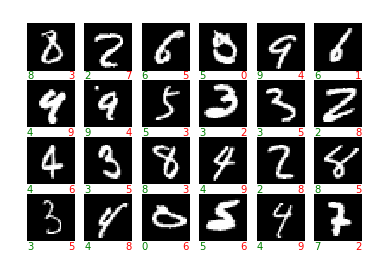

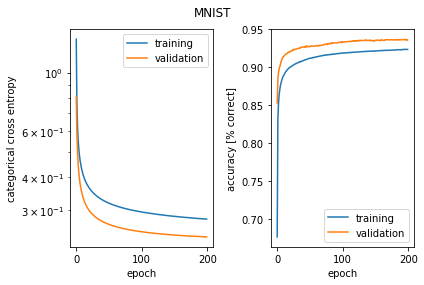

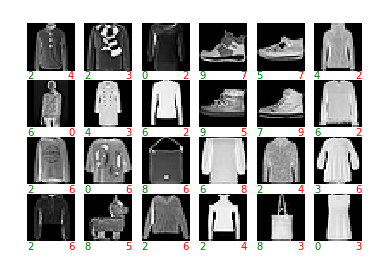

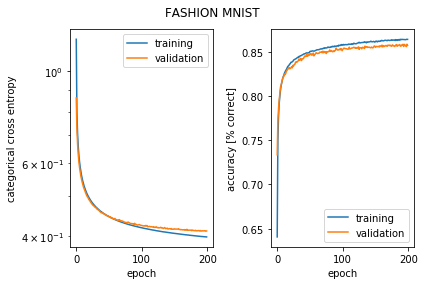

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import History 

def ex2(x_train,y_train,x_test,y_test,epochs,title):
    history = History()
    model = Sequential()
    model.add(Dense(10, input_dim=784))
    model.add(Activation('softmax'))
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train,validation_split=0.1, epochs=epochs, batch_size=128,callbacks=[history])
    y_pred = model.predict(x_test,batch_size=128)
    indices = []
    for i in range(y_pred.shape[0]):
        if np.argmax(y_pred[i])==np.argmax(y_test[i]):
            pass
        else:
            indices.append(i)
    plot_some_samples(x_test, y_test, y_pred, indices)
    plot_history(history,title)

ex2(x_train,y_train,x_test,y_test,200,'MNIST')
ex2(x_fashion_train,y_fashion_train,x_fashion_test,y_fashion_test,200,'FASHION MNIST')


Answer to 8 : The green digits represent the y class label for every number in the test sample set supplied (X_test). The red digits represent the predicted y class label for every number in the test sample set supplied.

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [31]:
def ex3(x_train,y_train,x_test,y_test,epochs,title,opt,lr=0.01):
    history = History()
    model = Sequential()
    model.add(Dense(128, input_dim=784, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    #model.add(Activation('softmax'))
    
    opt_func = None
    if(opt == 'sgd'):
        opt_func =keras.optimizers.SGD(lr=lr, momentum=0.0, decay=0.0, nesterov=False)
    else:
        opt_func = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    model.compile(optimizer=opt_func,loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(x_train, y_train,validation_split=0.1, epochs=epochs, batch_size=128,callbacks=[history])
    model.summary()
    plot_history(history,title)
    return history
    


Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 2s 45us/step - loss: 0.7673 - acc: 0.8116 - val_loss: 0.3559 - val_acc: 0.9097
Epoch 2/50
54000/54000 [==============================] - 1s 26us/step - loss: 0.3797 - acc: 0.8964 - val_loss: 0.2822 - val_acc: 0.9222
Epoch 3/50
54000/54000 [==============================] - 1s 26us/step - loss: 0.3248 - acc: 0.9098 - val_loss: 0.2515 - val_acc: 0.9308
Epoch 4/50
54000/54000 [==============================] - 1s 25us/step - loss: 0.2941 - acc: 0.9180 - val_loss: 0.2309 - val_acc: 0.9348
Epoch 5/50
54000/54000 [==============================] - 1s 25us/step - loss: 0.2722 - acc: 0.9234 - val_loss: 0.2166 - val_acc: 0.9388
Epoch 6/50
54000/54000 [==============================] - 1s 25us/step - loss: 0.2546 - acc: 0.9281 - val_loss: 0.2032 - val_acc: 0.9430
Epoch 7/50
54000/54000 [==============================] - 1s 27us/step - loss: 0.2401 - acc: 0.9322 - val_loss: 0.1921 - val_acc:

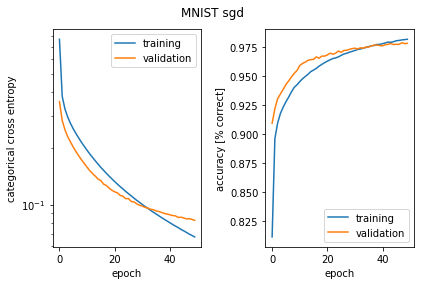

In [39]:
history_sgd = ex3(x_train,y_train,x_test,y_test,50,'MNIST sgd','sgd',lr=0.03)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 3s 54us/step - loss: 0.2904 - acc: 0.9152 - val_loss: 0.1781 - val_acc: 0.9462
Epoch 2/50
54000/54000 [==============================] - 2s 39us/step - loss: 0.2112 - acc: 0.9419 - val_loss: 0.1851 - val_acc: 0.9507
Epoch 3/50
54000/54000 [==============================] - 2s 41us/step - loss: 0.1938 - acc: 0.9482 - val_loss: 0.1872 - val_acc: 0.9475
Epoch 4/50
54000/54000 [==============================] - 3s 47us/step - loss: 0.1845 - acc: 0.9514 - val_loss: 0.1684 - val_acc: 0.9583
Epoch 5/50
54000/54000 [==============================] - 3s 48us/step - loss: 0.1706 - acc: 0.9580 - val_loss: 0.2007 - val_acc: 0.9507
Epoch 6/50
54000/54000 [==============================] - 3s 50us/step - loss: 0.1568 - acc: 0.9599 - val_loss: 0.1740 - val_acc: 0.9618
Epoch 7/50
54000/54000 [==============================] - 3s 52us/step - loss: 0.1773 - acc: 0.9571 - val_loss: 0.2039 - val_acc:

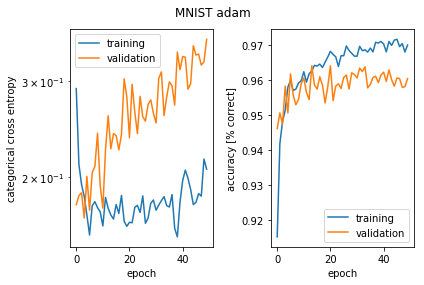

In [40]:
history_adam = ex3(x_train,y_train,x_test,y_test,50,'MNIST adam','adam',lr=0.03)

In [41]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

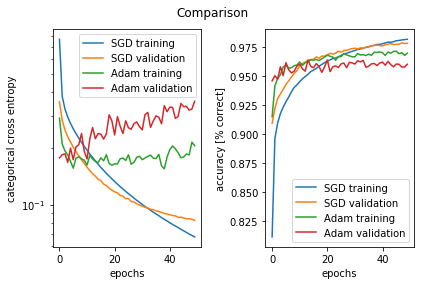

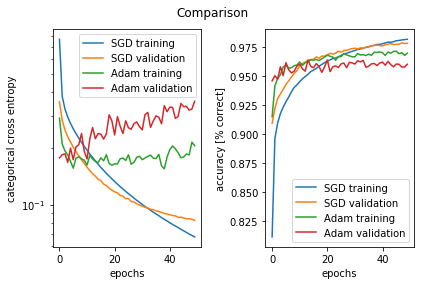

In [43]:
comparison_plot(history_sgd, history_adam, 'SGD', 'Adam', 'Comparison')

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 3s 50us/step - loss: 1.5015 - acc: 0.7506 - val_loss: 0.4521 - val_acc: 0.8407
Epoch 2/50
54000/54000 [==============================] - 2s 31us/step - loss: 0.4495 - acc: 0.8412 - val_loss: 0.4741 - val_acc: 0.8372
Epoch 3/50
54000/54000 [==============================] - 2s 31us/step - loss: 0.4230 - acc: 0.8499 - val_loss: 0.4434 - val_acc: 0.8515
Epoch 4/50
54000/54000 [==============================] - 2s 31us/step - loss: 0.4152 - acc: 0.8525 - val_loss: 0.4517 - val_acc: 0.8505
Epoch 5/50
54000/54000 [==============================] - 2s 31us/step - loss: 0.4218 - acc: 0.8501 - val_loss: 0.4622 - val_acc: 0.8425
Epoch 6/50
54000/54000 [==============================] - 2s 31us/step - loss: 0.4247 - acc: 0.8486 - val_loss: 0.5120 - val_acc: 0.8403
Epoch 7/50
54000/54000 [==============================] - 2s 31us/step - loss: 0.4128 - acc: 0.8557 - val_loss: 0.4888 - val_acc:

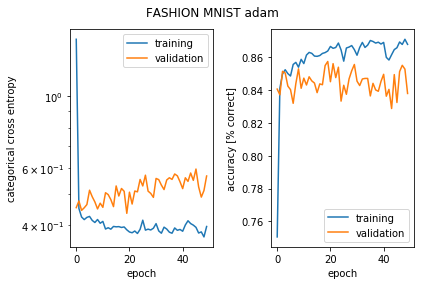

In [46]:
ex3(x_fashion_train,y_fashion_train,x_fashion_test,y_fashion_test,50,'FASHION MNIST adam','adam', lr=0.03)

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) when the learning rate is large, one of the following could happen depending on the initialization and topography of the loss function:  
      -Loss decreases rapidly but as we approach minimum, the loss increases and sometimes entirely diverges, that's because we overshoot the minima and can't converge to an optima.  
      -Loss oscillates, that's when topology is a valley.

B) when the learning rate is very small, the training needs more number of epochs but it could also be that we get trapped in local minima and never leave. 

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: At around Epoch 15, Adam optimizer starts to overfit (on MNIST)

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: When the model starts overfitting, the validation loss starts to increase while the training loss keeps decreasing . In the accuracy curve, however, the training accuracy keeps increasing while the validation accuracy remains the same or starts to decrease. 

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [10]:
def ex4(x_train,y_train,x_test,y_test,epochs,title,hidden_neurons = 10, lr=0.01):
    history = History()
    model = Sequential()
    model.add(Dense(hidden_neurons, input_dim=784, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    opt_func = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)   
    model.compile(optimizer=opt_func,loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(x_train, y_train,validation_split=0.1, epochs=epochs, batch_size=128,callbacks=[history])
    model.summary()
    plot_history(history,title)
    return history

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 8s 140us/step - loss: 0.8356 - acc: 0.7659 - val_loss: 0.3524 - val_acc: 0.9142
Epoch 2/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.3582 - acc: 0.9009 - val_loss: 0.2649 - val_acc: 0.9292
Epoch 3/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.3042 - acc: 0.9148 - val_loss: 0.2374 - val_acc: 0.9343
Epoch 4/100
54000/54000 [==============================] - 2s 37us/step - loss: 0.2808 - acc: 0.9201 - val_loss: 0.2300 - val_acc: 0.9345
Epoch 5/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.2677 - acc: 0.9246 - val_loss: 0.2180 - val_acc: 0.9395
Epoch 6/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.2573 - acc: 0.9264 - val_loss: 0.2090 - val_acc: 0.9422
Epoch 7/100
54000/54000 [==============================] - 2s 37us/step - loss: 0.2500 - acc: 0.9283 - val_loss: 0.2089 - 

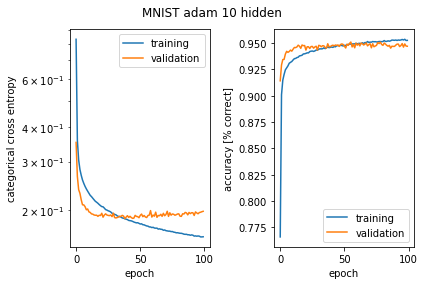

In [12]:
#part 1 
# MNIST
history1 = ex4(x_train,y_train,x_test,y_test,100,'MNIST adam 10 hidden', hidden_neurons = 10, lr=0.001)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 2s 39us/step - loss: 0.4862 - acc: 0.8699 - val_loss: 0.2190 - val_acc: 0.9407
Epoch 2/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.2305 - acc: 0.9353 - val_loss: 0.1621 - val_acc: 0.9552
Epoch 3/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.1793 - acc: 0.9495 - val_loss: 0.1381 - val_acc: 0.9603
Epoch 4/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.1490 - acc: 0.9579 - val_loss: 0.1199 - val_acc: 0.9663
Epoch 5/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.1270 - acc: 0.9640 - val_loss: 0.1106 - val_acc: 0.9700
Epoch 6/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.1112 - acc: 0.9677 - val_loss: 0.1049 - val_acc: 0.9693
Epoch 7/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.0986 - acc: 0.9715 - val_loss: 0.1003 - v

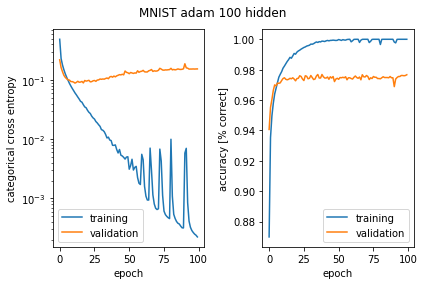

In [13]:
# MNIST
history2 = ex4(x_train,y_train,x_test,y_test,100,'MNIST adam 100 hidden', hidden_neurons = 50, lr=0.001)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 2s 41us/step - loss: 0.3415 - acc: 0.9055 - val_loss: 0.1536 - val_acc: 0.9598
Epoch 2/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.1552 - acc: 0.9557 - val_loss: 0.1102 - val_acc: 0.9717
Epoch 3/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.1071 - acc: 0.9695 - val_loss: 0.0962 - val_acc: 0.9727
Epoch 4/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0806 - acc: 0.9763 - val_loss: 0.0867 - val_acc: 0.9748
Epoch 5/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.0629 - acc: 0.9816 - val_loss: 0.0779 - val_acc: 0.9798
Epoch 6/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0497 - acc: 0.9856 - val_loss: 0.0733 - val_acc: 0.9783
Epoch 7/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0402 - acc: 0.9889 - val_loss: 0.0693 - v

Epoch 59/100
54000/54000 [==============================] - 2s 32us/step - loss: 5.0502e-05 - acc: 1.0000 - val_loss: 0.0905 - val_acc: 0.9823
Epoch 60/100
54000/54000 [==============================] - 2s 33us/step - loss: 4.5199e-05 - acc: 1.0000 - val_loss: 0.0908 - val_acc: 0.9822
Epoch 61/100
54000/54000 [==============================] - 2s 32us/step - loss: 4.0940e-05 - acc: 1.0000 - val_loss: 0.0906 - val_acc: 0.9828
Epoch 62/100
54000/54000 [==============================] - 2s 32us/step - loss: 3.5724e-05 - acc: 1.0000 - val_loss: 0.0905 - val_acc: 0.9827
Epoch 63/100
54000/54000 [==============================] - 2s 33us/step - loss: 3.2053e-05 - acc: 1.0000 - val_loss: 0.0914 - val_acc: 0.9828
Epoch 64/100
54000/54000 [==============================] - 2s 32us/step - loss: 3.1744e-05 - acc: 1.0000 - val_loss: 0.0916 - val_acc: 0.9833
Epoch 65/100
54000/54000 [==============================] - 2s 32us/step - loss: 0.0106 - acc: 0.9974 - val_loss: 0.1233 - val_acc: 0.9770
Epo

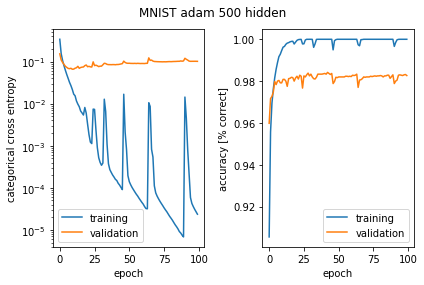

In [14]:
# MNIST
history3 = ex4(x_train,y_train,x_test,y_test,100,'MNIST adam 500 hidden', hidden_neurons = 200, lr=0.001)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 3s 49us/step - loss: 0.2878 - acc: 0.9181 - val_loss: 0.1328 - val_acc: 0.9622
Epoch 2/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.1178 - acc: 0.9659 - val_loss: 0.0915 - val_acc: 0.9747
Epoch 3/100
54000/54000 [==============================] - 2s 33us/step - loss: 0.0764 - acc: 0.9776 - val_loss: 0.0738 - val_acc: 0.9783
Epoch 4/100
54000/54000 [==============================] - 2s 40us/step - loss: 0.0553 - acc: 0.9838 - val_loss: 0.0766 - val_acc: 0.9807
Epoch 5/100
54000/54000 [==============================] - 3s 51us/step - loss: 0.0398 - acc: 0.9884 - val_loss: 0.0752 - val_acc: 0.9772
Epoch 6/100
54000/54000 [==============================] - 2s 38us/step - loss: 0.0298 - acc: 0.9918 - val_loss: 0.0652 - val_acc: 0.9818
Epoch 7/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0233 - acc: 0.9936 - val_loss: 0.0666 - v

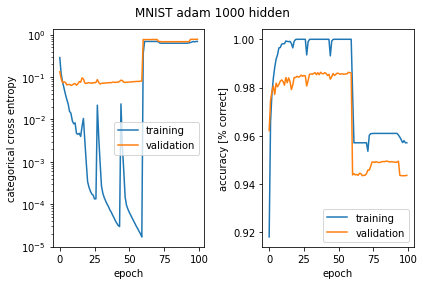

In [15]:
# MNIST
history4 = ex4(x_train,y_train,x_test,y_test,100,'MNIST adam 1000 hidden', hidden_neurons = 500, lr=0.001)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 3s 49us/step - loss: 0.2519 - acc: 0.9281 - val_loss: 0.1071 - val_acc: 0.9707
Epoch 2/100
54000/54000 [==============================] - 2s 44us/step - loss: 0.0960 - acc: 0.9714 - val_loss: 0.0863 - val_acc: 0.9745
Epoch 3/100
54000/54000 [==============================] - 2s 43us/step - loss: 0.0597 - acc: 0.9825 - val_loss: 0.0691 - val_acc: 0.9798
Epoch 4/100
54000/54000 [==============================] - 2s 38us/step - loss: 0.0412 - acc: 0.9875 - val_loss: 0.0657 - val_acc: 0.9820
Epoch 5/100
54000/54000 [==============================] - 2s 40us/step - loss: 0.0283 - acc: 0.9917 - val_loss: 0.0631 - val_acc: 0.9820
Epoch 6/100
54000/54000 [==============================] - 2s 37us/step - loss: 0.0214 - acc: 0.9940 - val_loss: 0.0606 - val_acc: 0.9823
Epoch 7/100
54000/54000 [==============================] - 2s 37us/step - loss: 0.0148 - acc: 0.9961 - val_loss: 0.0700 - v

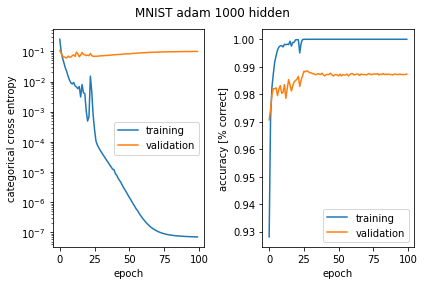

In [16]:
# MNIST
history5 = ex4(x_train,y_train,x_test,y_test,100,'MNIST adam 1000 hidden', hidden_neurons = 1000, lr=0.001)

In [8]:
# Comparison

def plot_metrics(model_histories, hidden_neurons, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'hidden neurons')
    val_loss = []
    val_acc = []
    for i, history in enumerate(model_histories):
        val_loss.append(min(history.history['val_loss']))
        val_acc.append(max(history.history['val_acc']))
    print(val_loss, val_acc)
    ax1.plot(hidden_neurons, val_loss)
    ax2.plot(hidden_neurons, val_acc)
    finalize_standardplot(fig, ax1, ax2)
    return fig

[0.1863454183737437, 0.08861621282498042, 0.06619350932538509, 0.06313656074305375, 0.06056988065193097] [0.9510000007947286, 0.9768333339691162, 0.9841666679382324, 0.9863333339691163, 0.9885000006357829]


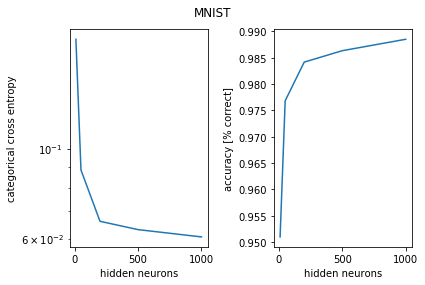

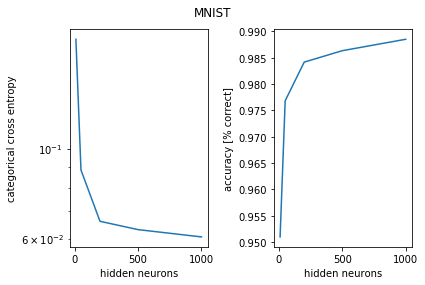

In [19]:
#part 2
#MNIST
hidden_neurons = [10, 50,200, 500,1000]
plot_metrics([history1, history2, history3,history4,history5], hidden_neurons, 'MNIST')

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 7s 134us/step - loss: 0.9706 - acc: 0.6826 - val_loss: 0.5944 - val_acc: 0.7992
Epoch 2/100
54000/54000 [==============================] - 2s 32us/step - loss: 0.5452 - acc: 0.8131 - val_loss: 0.5020 - val_acc: 0.8177
Epoch 3/100
54000/54000 [==============================] - 2s 30us/step - loss: 0.4806 - acc: 0.8340 - val_loss: 0.4624 - val_acc: 0.8350
Epoch 4/100
54000/54000 [==============================] - 2s 30us/step - loss: 0.4483 - acc: 0.8445 - val_loss: 0.4508 - val_acc: 0.8370
Epoch 5/100
54000/54000 [==============================] - 2s 32us/step - loss: 0.4257 - acc: 0.8521 - val_loss: 0.4279 - val_acc: 0.8433
Epoch 6/100
54000/54000 [==============================] - 2s 30us/step - loss: 0.4138 - acc: 0.8550 - val_loss: 0.4185 - val_acc: 0.8512
Epoch 7/100
54000/54000 [==============================] - 2s 31us/step - loss: 0.4042 - acc: 0.8590 - val_loss: 0.4122 - 

54000/54000 [==============================] - 4s 69us/step - loss: 0.2908 - acc: 0.8946 - val_loss: 0.3397 - val_acc: 0.8802
Epoch 14/100
54000/54000 [==============================] - 4s 70us/step - loss: 0.2847 - acc: 0.8981 - val_loss: 0.3539 - val_acc: 0.8750
Epoch 15/100
54000/54000 [==============================] - 4s 68us/step - loss: 0.2812 - acc: 0.8984 - val_loss: 0.3523 - val_acc: 0.8740
Epoch 16/100
54000/54000 [==============================] - 4s 69us/step - loss: 0.2777 - acc: 0.8988 - val_loss: 0.3526 - val_acc: 0.8782
Epoch 17/100
54000/54000 [==============================] - 4s 69us/step - loss: 0.2679 - acc: 0.9036 - val_loss: 0.3512 - val_acc: 0.8788
Epoch 18/100
54000/54000 [==============================] - 4s 68us/step - loss: 0.2666 - acc: 0.9023 - val_loss: 0.3426 - val_acc: 0.8770
Epoch 19/100
54000/54000 [==============================] - ETA: 0s - loss: 0.2607 - acc: 0.906 - 4s 69us/step - loss: 0.2607 - acc: 0.9061 - val_loss: 0.3449 - val_acc: 0.8782
Ep

Epoch 72/100
54000/54000 [==============================] - 2s 38us/step - loss: 0.1499 - acc: 0.9457 - val_loss: 0.4322 - val_acc: 0.8823
Epoch 73/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.1478 - acc: 0.9468 - val_loss: 0.4210 - val_acc: 0.8882
Epoch 74/100
54000/54000 [==============================] - 2s 29us/step - loss: 0.1493 - acc: 0.9474 - val_loss: 0.4091 - val_acc: 0.8850
Epoch 75/100
54000/54000 [==============================] - 2s 31us/step - loss: 0.1448 - acc: 0.9484 - val_loss: 0.4186 - val_acc: 0.8830
Epoch 76/100
54000/54000 [==============================] - 2s 30us/step - loss: 0.1445 - acc: 0.9474 - val_loss: 0.4209 - val_acc: 0.8853
Epoch 77/100
54000/54000 [==============================] - 2s 30us/step - loss: 0.1458 - acc: 0.9477 - val_loss: 0.4140 - val_acc: 0.8868
Epoch 78/100
54000/54000 [==============================] - 2s 30us/step - loss: 0.1409 - acc: 0.9491 - val_loss: 0.4301 - val_acc: 0.8817
Epoch 79/100
54000/54000 [=

54000/54000 [==============================] - 2s 38us/step - loss: 0.0417 - acc: 0.9855 - val_loss: 0.5255 - val_acc: 0.8913
Epoch 86/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.0429 - acc: 0.9847 - val_loss: 0.5564 - val_acc: 0.8882
Epoch 87/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0457 - acc: 0.9828 - val_loss: 0.5759 - val_acc: 0.8913
Epoch 88/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.0389 - acc: 0.9869 - val_loss: 0.5479 - val_acc: 0.8940
Epoch 89/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.0380 - acc: 0.9863 - val_loss: 0.5571 - val_acc: 0.8927
Epoch 90/100
54000/54000 [==============================] - 2s 38us/step - loss: 0.0374 - acc: 0.9870 - val_loss: 0.5728 - val_acc: 0.8865
Epoch 91/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0416 - acc: 0.9852 - val_loss: 0.5923 - val_acc: 0.8862
Epoch 92/100
54000/54000 [==============

54000/54000 [==============================] - 2s 35us/step - loss: 0.0262 - acc: 0.9905 - val_loss: 0.6098 - val_acc: 0.8953
Epoch 99/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.0268 - acc: 0.9900 - val_loss: 0.6411 - val_acc: 0.8910
Epoch 100/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0295 - acc: 0.9890 - val_loss: 0.6158 - val_acc: 0.8927
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 3s 48us/step - loss

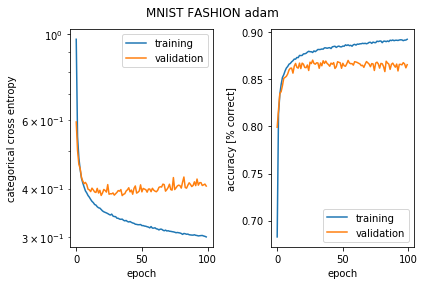

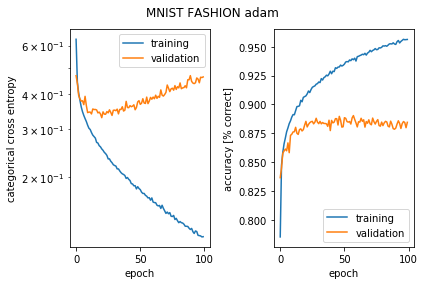

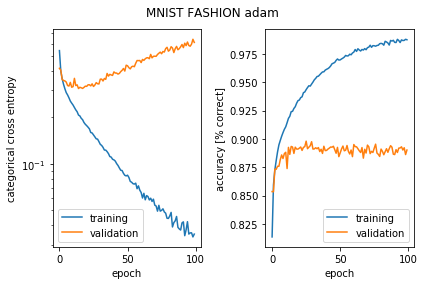

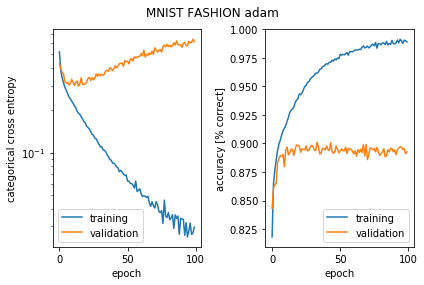

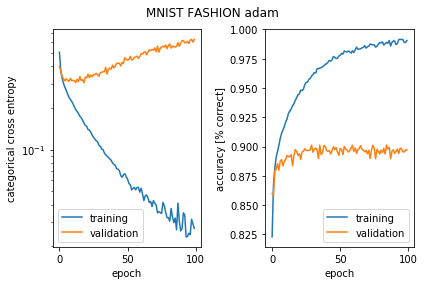

In [11]:
# part 3
# Fashion-MNIST
#part 3 - 1
hidden_neurons = [10, 50,200, 500,1000]
history1_f = ex4(x_fashion_train,y_fashion_train,x_fashion_test,y_fashion_test,100,'MNIST FASHION adam', hidden_neurons = 10, lr=0.001)
history2_f = ex4(x_fashion_train,y_fashion_train,x_fashion_test,y_fashion_test,100,'MNIST FASHION adam', hidden_neurons = 50, lr=0.001)
history3_f = ex4(x_fashion_train,y_fashion_train,x_fashion_test,y_fashion_test,100,'MNIST FASHION adam', hidden_neurons = 200, lr=0.001)
history4_f = ex4(x_fashion_train,y_fashion_train,x_fashion_test,y_fashion_test,100,'MNIST FASHION adam', hidden_neurons = 500, lr=0.001)
history5_f = ex4(x_fashion_train,y_fashion_train,x_fashion_test,y_fashion_test,100,'MNIST FASHION adam', hidden_neurons = 1000, lr=0.001)

[0.40763392686843875, 0.3318967679341634, 0.30176476287841797, 0.298402713060379, 0.2983828377723694] [0.8585000012715658, 0.8870000006357829, 0.8993333341280619, 0.9006666671435039, 0.8996666674613952]


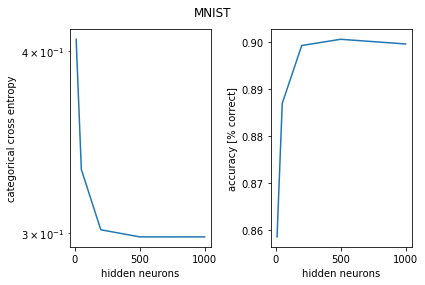

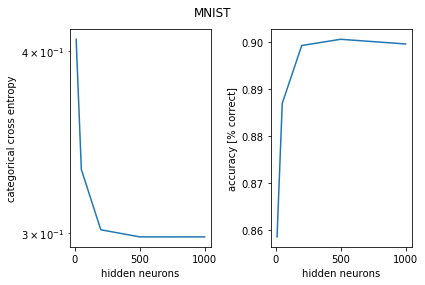

In [21]:

#part 3 - 2
plot_metrics([history1_f, history2_f, history3_f,history4_f,history5_f], hidden_neurons, 'MNIST')


Answer to question 2:

Yes, we can see that the loss drops as number of nodes ( width ) of the network increases from 10 to 50 and sharply drops as we further increase the width to 200 and then linearly drops as the width is increased further. In 2017 Lu et al showed that width-n+4 networks with ReLU activation functions can approximate any Lebesgue integrable function on n-dimensional input space if the depth of the network is allowed to grow. In this instance , even though we kept the depth limited, we can see empirical evidence of the network learing the best at 1000 nodes , ie when nodes > 788 ( n+4) . 

Lu, Z., Pu, H., Wang, F., Hu, Z., & Wang, L. (2017). The Expressive Power of Neural Networks: A View from the Width. Neural Information Processing Systems, 6231-6239.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [55]:
def ex5(x_train,y_train,x_test,y_test,epochs,title,hidden_neurons = 50,num_layers=2,batch_norm=True,reg='l2',add_dropout = False,k_reg = 0.001, dropout_rate = 0.2, lr=0.01):
    history = History()
    model = Sequential()
    
    if(reg == 'l1'):
        if(batch_norm):
            model.add(Dense(hidden_neurons, input_dim=784, kernel_regularizer = regularizers.l1(k_reg)))
            model.add(keras.layers.BatchNormalization())
            model.add(Activation('selu'))
        else:
            model.add(Dense(hidden_neurons, input_dim=784, activation='selu',kernel_regularizer = regularizers.l1(k_reg)))
    elif(reg == 'l2'):
        if(batch_norm):
            model.add(Dense(hidden_neurons, input_dim=784, kernel_regularizer = regularizers.l2(k_reg)))
            model.add(keras.layers.BatchNormalization())
            model.add(Activation('selu'))
        else:
            model.add(Dense(hidden_neurons, input_dim=784, activation='selu',kernel_regularizer = regularizers.l2(k_reg)))
    else:
        if(batch_norm):
            model.add(Dense(hidden_neurons, input_dim=784))
            model.add(keras.layers.BatchNormalization())
            model.add(Activation('selu'))
        else:
            model.add(Dense(hidden_neurons, input_dim=784, activation='selu'))

    if(add_dropout):
        model.add(keras.layers.Dropout(dropout_rate, noise_shape=None, seed=None))
        
    for i in range(num_layers-1):
        if(reg == 'l1'):
            if(batch_norm):
                model.add(Dense(hidden_neurons, kernel_regularizer = regularizers.l1(k_reg)))
                model.add(keras.layers.BatchNormalization())
                model.add(Activation('selu'))
            else:
                model.add(Dense(hidden_neurons,  activation='selu',kernel_regularizer = regularizers.l1(k_reg)))
        elif(reg == 'l2'):
            if(batch_norm):
                model.add(Dense(hidden_neurons, kernel_regularizer = regularizers.l2(k_reg)))
                model.add(keras.layers.BatchNormalization())
                model.add(Activation('selu'))
            else:
                model.add(Dense(hidden_neurons, activation='selu',kernel_regularizer = regularizers.l2(k_reg)))
        else:
            if(batch_norm):
                model.add(Dense(hidden_neurons))
                model.add(keras.layers.BatchNormalization())
                model.add(Activation('selu'))
            else:
                model.add(Dense(hidden_neurons, activation='selu'))
        if(add_dropout):
            model.add(keras.layers.Dropout(dropout_rate, noise_shape=None, seed=None))
    
    model.add(Dense(10))
    if(batch_norm):
        model.add(keras.layers.BatchNormalization())
    model.add(Activation('softmax'))
    
    opt_func = keras.optimizers.SGD(lr=lr, momentum=0.0, decay=0.0, nesterov=False)
    model.compile(optimizer=opt_func,loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(x_train, y_train,validation_split=0.1, epochs=epochs, batch_size=128,callbacks=[history])
    model.summary()
    plot_history(history,title)
    return history

Answer to question 2 (comments):

The best performing model is with No dropout and no batch normalization and with L2 regularization. with 3 hidden layers the model learns only until 87.5 % accuracy while with 1 hidden layer model learns until 90 % accuracy. With 3 layers the model starts learning some features which makes it start overfitting without generalization, so in this case deeper model doesn't help much. With dropout and batch normalization the accuracy is lower , meaning the model has a bias, so we need to have a wider model which can learn better like in previous part. 

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.8165 - acc: 0.7216 - val_loss: 0.5963 - val_acc: 0.7888
Epoch 2/100
54000/54000 [==============================] - 1s 23us/step - loss: 0.5552 - acc: 0.8053 - val_loss: 0.5133 - val_acc: 0.8182
Epoch 3/100
54000/54000 [==============================] - 1s 26us/step - loss: 0.4997 - acc: 0.8224 - val_loss: 0.4926 - val_acc: 0.8188
Epoch 4/100
54000/54000 [==============================] - 1s 23us/step - loss: 0.4700 - acc: 0.8339 - val_loss: 0.4591 - val_acc: 0.8328
Epoch 5/100
54000/54000 [==============================] - 1s 21us/step - loss: 0.4507 - acc: 0.8408 - val_loss: 0.4452 - val_acc: 0.8367
Epoch 6/100
54000/54000 [==============================] - 1s 21us/step - loss: 0.4342 - acc: 0.8453 - val_loss: 0.4424 - val_acc: 0.8422
Epoch 7/100
54000/54000 [==============================] - 1s 21us/step - loss: 0.4238 - acc: 0.8488 - val_loss: 0.4271 - v

54000/54000 [==============================] - 1s 27us/step - loss: 0.5842 - acc: 0.8580 - val_loss: 0.5844 - val_acc: 0.8510
Epoch 11/100
54000/54000 [==============================] - 1s 27us/step - loss: 0.5763 - acc: 0.8590 - val_loss: 0.5776 - val_acc: 0.8542
Epoch 12/100
54000/54000 [==============================] - 2s 28us/step - loss: 0.5693 - acc: 0.8604 - val_loss: 0.5771 - val_acc: 0.8547
Epoch 13/100
54000/54000 [==============================] - 2s 32us/step - loss: 0.5628 - acc: 0.8629 - val_loss: 0.5588 - val_acc: 0.8562
Epoch 14/100
54000/54000 [==============================] - 2s 28us/step - loss: 0.5565 - acc: 0.8637 - val_loss: 0.5568 - val_acc: 0.8577
Epoch 15/100
54000/54000 [==============================] - 1s 27us/step - loss: 0.5506 - acc: 0.8657 - val_loss: 0.5477 - val_acc: 0.8620
Epoch 16/100
54000/54000 [==============================] - 1s 28us/step - loss: 0.5444 - acc: 0.8669 - val_loss: 0.5482 - val_acc: 0.8572
Epoch 17/100
54000/54000 [==============

54000/54000 [==============================] - 1s 26us/step - loss: 0.4025 - acc: 0.8952 - val_loss: 0.4386 - val_acc: 0.8788
Epoch 70/100
54000/54000 [==============================] - 2s 29us/step - loss: 0.4000 - acc: 0.8951 - val_loss: 0.4536 - val_acc: 0.8732
Epoch 71/100
54000/54000 [==============================] - 2s 31us/step - loss: 0.3990 - acc: 0.8956 - val_loss: 0.4404 - val_acc: 0.8767
Epoch 72/100
54000/54000 [==============================] - 1s 27us/step - loss: 0.3980 - acc: 0.8953 - val_loss: 0.4616 - val_acc: 0.8695
Epoch 73/100
54000/54000 [==============================] - 2s 32us/step - loss: 0.3979 - acc: 0.8957 - val_loss: 0.4403 - val_acc: 0.8757
Epoch 74/100
54000/54000 [==============================] - 2s 28us/step - loss: 0.3945 - acc: 0.8963 - val_loss: 0.4446 - val_acc: 0.8745
Epoch 75/100
54000/54000 [==============================] - 1s 27us/step - loss: 0.3937 - acc: 0.8974 - val_loss: 0.4417 - val_acc: 0.8760
Epoch 76/100
54000/54000 [==============

54000/54000 [==============================] - 2s 28us/step - loss: 0.6122 - acc: 0.8536 - val_loss: 0.6139 - val_acc: 0.8522
Epoch 80/100
54000/54000 [==============================] - 1s 28us/step - loss: 0.6093 - acc: 0.8555 - val_loss: 0.6092 - val_acc: 0.8523
Epoch 81/100
54000/54000 [==============================] - 2s 28us/step - loss: 0.6075 - acc: 0.8549 - val_loss: 0.6120 - val_acc: 0.8482
Epoch 82/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.6036 - acc: 0.8564 - val_loss: 0.6536 - val_acc: 0.8287
Epoch 83/100
54000/54000 [==============================] - 2s 33us/step - loss: 0.6047 - acc: 0.8554 - val_loss: 0.6078 - val_acc: 0.8503
Epoch 84/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.6044 - acc: 0.8540 - val_loss: 0.6199 - val_acc: 0.8425
Epoch 85/100
54000/54000 [==============================] - 2s 29us/step - loss: 0.6027 - acc: 0.8547 - val_loss: 0.6124 - val_acc: 0.8503
Epoch 86/100
54000/54000 [==============

54000/54000 [==============================] - 1s 26us/step - loss: 0.7382 - acc: 0.8252 - val_loss: 0.6732 - val_acc: 0.8408
Epoch 90/100
54000/54000 [==============================] - 2s 29us/step - loss: 0.7345 - acc: 0.8249 - val_loss: 0.6854 - val_acc: 0.8397
Epoch 91/100
54000/54000 [==============================] - 1s 25us/step - loss: 0.7395 - acc: 0.8239 - val_loss: 0.6852 - val_acc: 0.8352
Epoch 92/100
54000/54000 [==============================] - 1s 25us/step - loss: 0.7382 - acc: 0.8234 - val_loss: 0.6841 - val_acc: 0.8400
Epoch 93/100
54000/54000 [==============================] - 1s 26us/step - loss: 0.7337 - acc: 0.8274 - val_loss: 0.6752 - val_acc: 0.8388
Epoch 94/100
54000/54000 [==============================] - 1s 25us/step - loss: 0.7349 - acc: 0.8268 - val_loss: 0.6815 - val_acc: 0.8355
Epoch 95/100
54000/54000 [==============================] - 1s 27us/step - loss: 0.7326 - acc: 0.8255 - val_loss: 0.6659 - val_acc: 0.8433
Epoch 96/100
54000/54000 [==============

Epoch 38/100
54000/54000 [==============================] - 1s 26us/step - loss: 0.5559 - acc: 0.8492 - val_loss: 0.5180 - val_acc: 0.8555
Epoch 39/100
54000/54000 [==============================] - 1s 26us/step - loss: 0.5556 - acc: 0.8474 - val_loss: 0.5161 - val_acc: 0.8577
Epoch 40/100
54000/54000 [==============================] - 1s 27us/step - loss: 0.5473 - acc: 0.8511 - val_loss: 0.5112 - val_acc: 0.8578
Epoch 41/100
54000/54000 [==============================] - 1s 26us/step - loss: 0.5501 - acc: 0.8483 - val_loss: 0.5138 - val_acc: 0.8538
Epoch 42/100
54000/54000 [==============================] - 1s 26us/step - loss: 0.5442 - acc: 0.8516 - val_loss: 0.5101 - val_acc: 0.8562
Epoch 43/100
54000/54000 [==============================] - 1s 26us/step - loss: 0.5458 - acc: 0.8499 - val_loss: 0.5086 - val_acc: 0.8563
Epoch 44/100
54000/54000 [==============================] - 1s 26us/step - loss: 0.5429 - acc: 0.8504 - val_loss: 0.5070 - val_acc: 0.8568
Epoch 45/100
54000/54000 [=

Epoch 97/100
54000/54000 [==============================] - 1s 26us/step - loss: 0.4732 - acc: 0.8607 - val_loss: 0.4595 - val_acc: 0.8617
Epoch 98/100
54000/54000 [==============================] - 1s 26us/step - loss: 0.4758 - acc: 0.8595 - val_loss: 0.4604 - val_acc: 0.8610
Epoch 99/100
54000/54000 [==============================] - 1s 27us/step - loss: 0.4742 - acc: 0.8591 - val_loss: 0.4533 - val_acc: 0.8608
Epoch 100/100
54000/54000 [==============================] - 1s 26us/step - loss: 0.4733 - acc: 0.8595 - val_loss: 0.4570 - val_acc: 0.8602
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 50)                39250     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 50)        

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 3s 64us/step - loss: 1.4784 - acc: 0.6141 - val_loss: 1.0470 - val_acc: 0.7627
Epoch 2/100
54000/54000 [==============================] - 2s 38us/step - loss: 1.1331 - acc: 0.7283 - val_loss: 0.9067 - val_acc: 0.7898
Epoch 3/100
54000/54000 [==============================] - 2s 38us/step - loss: 1.0076 - acc: 0.7595 - val_loss: 0.8194 - val_acc: 0.8098
Epoch 4/100
54000/54000 [==============================] - 2s 38us/step - loss: 0.9302 - acc: 0.7773 - val_loss: 0.7705 - val_acc: 0.8157
Epoch 5/100
54000/54000 [==============================] - 2s 38us/step - loss: 0.8770 - acc: 0.7894 - val_loss: 0.7392 - val_acc: 0.8198
Epoch 6/100
54000/54000 [==============================] - 2s 38us/step - loss: 0.8382 - acc: 0.7969 - val_loss: 0.7026 - val_acc: 0.8282
Epoch 7/100
54000/54000 [==============================] - 2s 38us/step - loss: 0.8091 - acc: 0.8032 - val_loss: 0.6852 - v

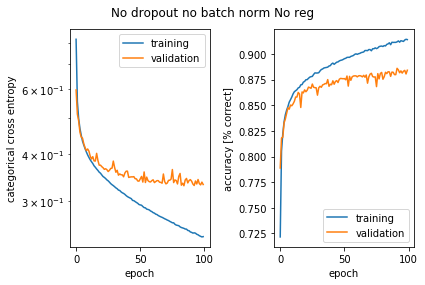

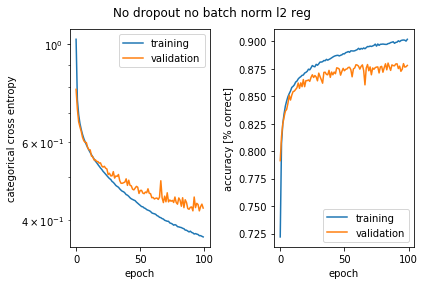

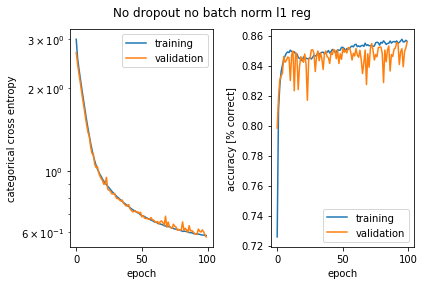

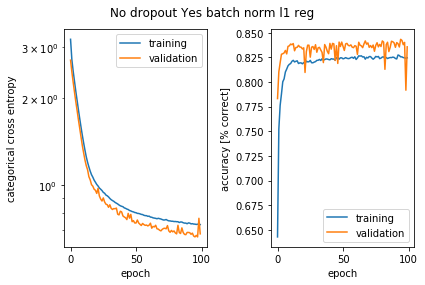

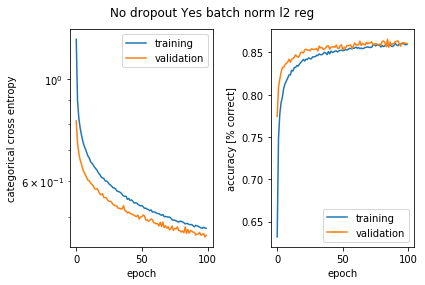

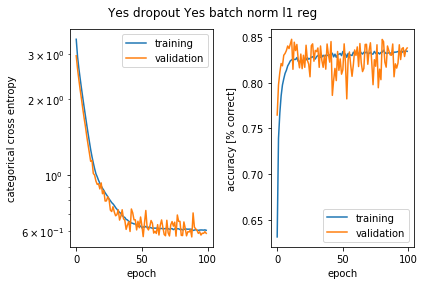

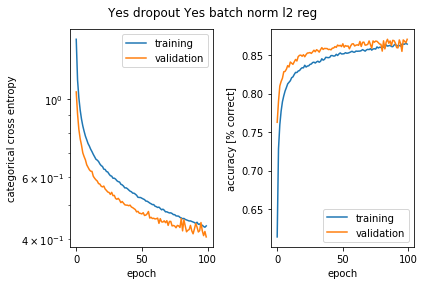

In [21]:
#part 1 and 2
history_no_dropout_no_batch_no_reg = ex5(x_fashion_train,y_fashion_train,x_fashion_train,y_fashion_test,epochs=100,title='No dropout no batch norm No reg',hidden_neurons = 50,num_layers=3,batch_norm=False,reg='no',add_dropout = False)
history_no_dropout_no_batch_l2_reg = ex5(x_fashion_train,y_fashion_train,x_fashion_train,y_fashion_test,epochs=100,title='No dropout no batch norm l2 reg',hidden_neurons = 50,num_layers=3,batch_norm=False,reg='l2',add_dropout = False)
history_no_dropout_no_batch_l1_reg = ex5(x_fashion_train,y_fashion_train,x_fashion_train,y_fashion_test,epochs=100,title='No dropout no batch norm l1 reg',hidden_neurons = 50,num_layers=3,batch_norm=False,reg='l1',add_dropout = False)
history_dropout_no_batch_l1_reg = ex5(x_fashion_train,y_fashion_train,x_fashion_train,y_fashion_test,epochs=100,title='No dropout Yes batch norm l1 reg',hidden_neurons = 50,num_layers=3,batch_norm=False,reg='l1',add_dropout = True)
history_dropout_no_batch_l2_reg = ex5(x_fashion_train,y_fashion_train,x_fashion_train,y_fashion_test,epochs=100,title='No dropout Yes batch norm l2 reg',hidden_neurons = 50,num_layers=3,batch_norm=False,reg='l2',add_dropout = True)
history_dropout__batch_l1_reg = ex5(x_fashion_train,y_fashion_train,x_fashion_train,y_fashion_test,epochs=100,title='Yes dropout Yes batch norm l1 reg',hidden_neurons = 50,num_layers=3,batch_norm=True,reg='l1',add_dropout = True)
history_dropout__batch_l2_reg = ex5(x_fashion_train,y_fashion_train,x_fashion_train,y_fashion_test,epochs=100,title='Yes dropout Yes batch norm l2 reg',hidden_neurons = 50,num_layers=3,batch_norm=True,reg='l2',add_dropout = True)



Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 11s 208us/step - loss: 0.9829 - acc: 0.7785 - val_loss: 0.5820 - val_acc: 0.9008
Epoch 2/100
54000/54000 [==============================] - 2s 38us/step - loss: 0.6007 - acc: 0.8875 - val_loss: 0.4974 - val_acc: 0.9153
Epoch 3/100
54000/54000 [==============================] - 2s 37us/step - loss: 0.5417 - acc: 0.9020 - val_loss: 0.4669 - val_acc: 0.9215
Epoch 4/100
54000/54000 [==============================] - 2s 39us/step - loss: 0.5109 - acc: 0.9097 - val_loss: 0.4468 - val_acc: 0.9288
Epoch 5/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.4900 - acc: 0.9155 - val_loss: 0.4309 - val_acc: 0.9308
Epoch 6/100
54000/54000 [==============================] - 2s 38us/step - loss: 0.4739 - acc: 0.9188 - val_loss: 0.4176 - val_acc: 0.9370
Epoch 7/100
54000/54000 [==============================] - 2s 40us/step - loss: 0.4600 - acc: 0.9222 - val_loss: 0.4069 -

54000/54000 [==============================] - 2s 41us/step - loss: 0.2191 - acc: 0.9745 - val_loss: 0.2260 - val_acc: 0.9712
Epoch 60/100
54000/54000 [==============================] - 2s 39us/step - loss: 0.2170 - acc: 0.9746 - val_loss: 0.2237 - val_acc: 0.9702
Epoch 61/100
54000/54000 [==============================] - 2s 38us/step - loss: 0.2151 - acc: 0.9747 - val_loss: 0.2210 - val_acc: 0.9712
Epoch 62/100
54000/54000 [==============================] - 2s 38us/step - loss: 0.2135 - acc: 0.9752 - val_loss: 0.2198 - val_acc: 0.9710
Epoch 63/100
54000/54000 [==============================] - 2s 39us/step - loss: 0.2116 - acc: 0.9754 - val_loss: 0.2192 - val_acc: 0.9712
Epoch 64/100
54000/54000 [==============================] - 2s 44us/step - loss: 0.2098 - acc: 0.9762 - val_loss: 0.2168 - val_acc: 0.9718
Epoch 65/100
54000/54000 [==============================] - 2s 39us/step - loss: 0.2079 - acc: 0.9762 - val_loss: 0.2174 - val_acc: 0.9703
Epoch 66/100
54000/54000 [==============

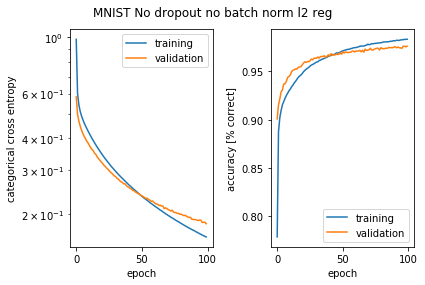

In [56]:
#part 3 
history_no_dropout_no_batch_l2_reg = ex5(x_train,y_train,x_fashion_test,y_test,epochs=100,title='MNIST No dropout no batch norm l2 reg',hidden_neurons = 50,num_layers=3,batch_norm=False,reg='l2',add_dropout = False)


## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [8]:
def ex6(x_train, y_train,x_test,y_test,title,epochs=100,activation='relu',batch_norm=False):
    history=History()
    model = Sequential()
    input_shape = ( 28, 28,1)
    x_train = x_train.reshape(x_train.shape[0],28, 28,1)
    x_test = x_test.reshape(x_test.shape[0],28,28,1)
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=None,
                     input_shape=input_shape))
    if(batch_norm):
        model.add(keras.layers.BatchNormalization())
    model.add(Activation(activation))
    model.add(Conv2D(64, (3, 3), activation=None))
    if(batch_norm):
        model.add(keras.layers.BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=None))
    if(batch_norm):
        model.add(keras.layers.BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation=None))
    if(batch_norm):
        model.add(keras.layers.BatchNormalization())
    model.add(Activation('softmax'))
    model.compile(optimizer=keras.optimizers.Adadelta(),loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(x_train, y_train,validation_split=0.1, epochs=epochs, batch_size=128,callbacks=[history])
    model.summary()
    print("******test accuracy is below*********")
    print(model.evaluate(x_test,y_test))
    plot_history(history,title)
    return history,model

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 10s 190us/step - loss: 0.3105 - acc: 0.9042 - val_loss: 0.0595 - val_acc: 0.9820
Epoch 2/100
54000/54000 [==============================] - 9s 171us/step - loss: 0.1019 - acc: 0.9699 - val_loss: 0.0429 - val_acc: 0.9858
Epoch 3/100
54000/54000 [==============================] - 9s 169us/step - loss: 0.0717 - acc: 0.9790 - val_loss: 0.0448 - val_acc: 0.9893
Epoch 4/100
54000/54000 [==============================] - 9s 170us/step - loss: 0.0597 - acc: 0.9820 - val_loss: 0.0377 - val_acc: 0.9898
Epoch 5/100
54000/54000 [==============================] - 12s 213us/step - loss: 0.0514 - acc: 0.9847 - val_loss: 0.0371 - val_acc: 0.9893
Epoch 6/100
54000/54000 [==============================] - 12s 216us/step - loss: 0.0459 - acc: 0.9865 - val_loss: 0.0327 - val_acc: 0.9905
Epoch 7/100
54000/54000 [==============================] - 12s 218us/step - loss: 0.0404 - acc: 0.9881 - val_loss:

Epoch 59/100
54000/54000 [==============================] - 9s 170us/step - loss: 0.0131 - acc: 0.9957 - val_loss: 0.0340 - val_acc: 0.9925
Epoch 60/100
54000/54000 [==============================] - 9s 167us/step - loss: 0.0115 - acc: 0.9965 - val_loss: 0.0402 - val_acc: 0.9918
Epoch 61/100
54000/54000 [==============================] - 9s 171us/step - loss: 0.0109 - acc: 0.9968 - val_loss: 0.0384 - val_acc: 0.9927
Epoch 62/100
54000/54000 [==============================] - 10s 178us/step - loss: 0.0115 - acc: 0.9965 - val_loss: 0.0307 - val_acc: 0.9935
Epoch 63/100
54000/54000 [==============================] - 12s 217us/step - loss: 0.0113 - acc: 0.9967 - val_loss: 0.0454 - val_acc: 0.9920
Epoch 64/100
54000/54000 [==============================] - 11s 213us/step - loss: 0.0114 - acc: 0.9965 - val_loss: 0.0333 - val_acc: 0.9930
Epoch 65/100
54000/54000 [==============================] - 11s 206us/step - loss: 0.0117 - acc: 0.9964 - val_loss: 0.0424 - val_acc: 0.9928
Epoch 66/100
540

54000/54000 [==============================] - 120s 2ms/step - loss: 0.0650 - acc: 0.9777 - val_loss: 0.2649 - val_acc: 0.9343
Epoch 62/100
54000/54000 [==============================] - 120s 2ms/step - loss: 0.0676 - acc: 0.9773 - val_loss: 0.2825 - val_acc: 0.9343
Epoch 63/100
54000/54000 [==============================] - 121s 2ms/step - loss: 0.0686 - acc: 0.9772 - val_loss: 0.2422 - val_acc: 0.9295
Epoch 64/100
54000/54000 [==============================] - 120s 2ms/step - loss: 0.0648 - acc: 0.9778 - val_loss: 0.2919 - val_acc: 0.9340
Epoch 65/100
54000/54000 [==============================] - 122s 2ms/step - loss: 0.0636 - acc: 0.9776 - val_loss: 0.2946 - val_acc: 0.9343
Epoch 66/100
54000/54000 [==============================] - 122s 2ms/step - loss: 0.0654 - acc: 0.9776 - val_loss: 0.2884 - val_acc: 0.9333
Epoch 67/100
54000/54000 [==============================] - 122s 2ms/step - loss: 0.0645 - acc: 0.9778 - val_loss: 0.2764 - val_acc: 0.9293
Epoch 68/100
54000/54000 [=======

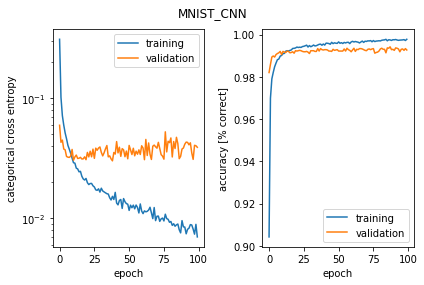

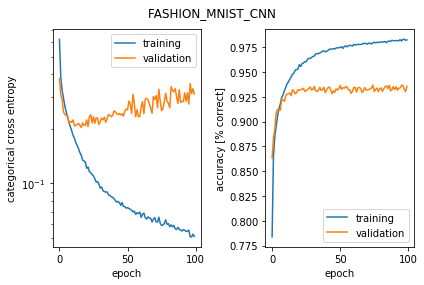

In [36]:
history_cnn_mnist,_ = ex6(x_train,y_train,x_test,y_test,'MNIST_CNN')
history_cnn_fashion_mnist,_ = ex6(x_fashion_train,y_fashion_train,x_fashion_test,y_fashion_test,'FASHION_MNIST_CNN')

(60000, 1, 28, 28)

Answer to question 3:

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 13s 244us/step - loss: 2.3128 - acc: 0.1022 - val_loss: 2.3028 - val_acc: 0.0925
Epoch 2/100
54000/54000 [==============================] - 7s 134us/step - loss: 2.2451 - acc: 0.1289 - val_loss: 1.2051 - val_acc: 0.4942
Epoch 3/100
54000/54000 [==============================] - 7s 135us/step - loss: 0.7634 - acc: 0.7130 - val_loss: 0.5662 - val_acc: 0.7887
Epoch 4/100
54000/54000 [==============================] - 7s 135us/step - loss: 0.6067 - acc: 0.7716 - val_loss: 0.4987 - val_acc: 0.8110
Epoch 5/100
54000/54000 [==============================] - 7s 134us/step - loss: 0.5504 - acc: 0.7956 - val_loss: 0.4624 - val_acc: 0.8222
Epoch 6/100
54000/54000 [==============================] - 7s 134us/step - loss: 0.5137 - acc: 0.8095 - val_loss: 0.4349 - val_acc: 0.8363
Epoch 7/100
54000/54000 [==============================] - 7s 134us/step - loss: 0.4872 - acc: 0.8202 - val_loss: 0.

54000/54000 [==============================] - 7s 134us/step - loss: 0.2211 - acc: 0.9181 - val_loss: 0.2298 - val_acc: 0.9200
Epoch 60/100
54000/54000 [==============================] - 7s 134us/step - loss: 0.2225 - acc: 0.9189 - val_loss: 0.2266 - val_acc: 0.9208
Epoch 61/100
54000/54000 [==============================] - 7s 135us/step - loss: 0.2219 - acc: 0.9194 - val_loss: 0.2309 - val_acc: 0.9187
Epoch 62/100
54000/54000 [==============================] - 7s 134us/step - loss: 0.2197 - acc: 0.9193 - val_loss: 0.2435 - val_acc: 0.9090
Epoch 63/100
54000/54000 [==============================] - 7s 134us/step - loss: 0.2189 - acc: 0.9192 - val_loss: 0.2337 - val_acc: 0.9162
Epoch 64/100
54000/54000 [==============================] - 7s 135us/step - loss: 0.2164 - acc: 0.9210 - val_loss: 0.2207 - val_acc: 0.9192
Epoch 65/100
54000/54000 [==============================] - 7s 134us/step - loss: 0.2147 - acc: 0.9217 - val_loss: 0.2279 - val_acc: 0.9182
Epoch 66/100
54000/54000 [=======

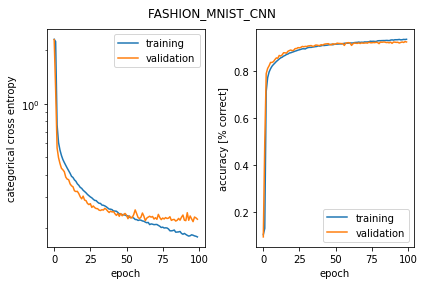

In [9]:
#part 1 
history_cnn_fashion_mnist_sigmoid,sigmoid_model = ex6(x_fashion_train,y_fashion_train,x_fashion_test,y_fashion_test,'FASHION_MNIST_CNN',activation='sigmoid')


Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 13s 236us/step - loss: 0.9183 - acc: 0.7600 - val_loss: 0.5223 - val_acc: 0.8547
Epoch 2/100
54000/54000 [==============================] - 11s 198us/step - loss: 0.6004 - acc: 0.8390 - val_loss: 0.4347 - val_acc: 0.8600
Epoch 3/100
54000/54000 [==============================] - 11s 197us/step - loss: 0.4749 - acc: 0.8635 - val_loss: 0.3421 - val_acc: 0.8920
Epoch 4/100
54000/54000 [==============================] - 11s 198us/step - loss: 0.4117 - acc: 0.8749 - val_loss: 0.3122 - val_acc: 0.9000
Epoch 5/100
54000/54000 [==============================] - 11s 198us/step - loss: 0.3663 - acc: 0.8864 - val_loss: 0.2972 - val_acc: 0.8977
Epoch 6/100
54000/54000 [==============================] - 11s 199us/step - loss: 0.3367 - acc: 0.8935 - val_loss: 0.2687 - val_acc: 0.9090
Epoch 7/100
54000/54000 [==============================] - 11s 197us/step - loss: 0.3132 - acc: 0.8977 - val_lo

Epoch 59/100
54000/54000 [==============================] - 11s 198us/step - loss: 0.0779 - acc: 0.9735 - val_loss: 0.1994 - val_acc: 0.9388
Epoch 60/100
54000/54000 [==============================] - 11s 201us/step - loss: 0.0762 - acc: 0.9739 - val_loss: 0.1876 - val_acc: 0.9388
Epoch 61/100
54000/54000 [==============================] - 11s 199us/step - loss: 0.0741 - acc: 0.9739 - val_loss: 0.2062 - val_acc: 0.9375
Epoch 62/100
54000/54000 [==============================] - 11s 196us/step - loss: 0.0746 - acc: 0.9741 - val_loss: 0.1868 - val_acc: 0.9352
Epoch 63/100
54000/54000 [==============================] - 10s 193us/step - loss: 0.0728 - acc: 0.9753 - val_loss: 0.1908 - val_acc: 0.9372
Epoch 64/100
54000/54000 [==============================] - 10s 192us/step - loss: 0.0717 - acc: 0.9751 - val_loss: 0.1888 - val_acc: 0.9367
Epoch 65/100
54000/54000 [==============================] - 10s 192us/step - loss: 0.0679 - acc: 0.9775 - val_loss: 0.1926 - val_acc: 0.9378
Epoch 66/100


10000/10000 [==============================] - 1s 108us/step
[0.25046748536769303, 0.9345]


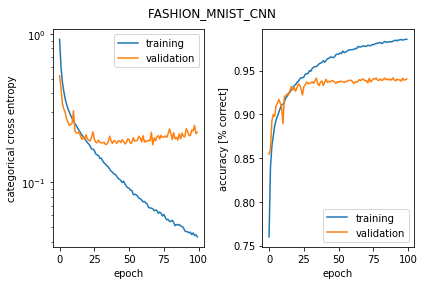

In [43]:
#part 2
history_cnn_fashion_mnist_batch,sigmoid_batch_model = ex6(x_fashion_train,y_fashion_train,x_fashion_test,y_fashion_test,'FASHION_MNIST_CNN',batch_norm=True,activation='sigmoid')


conv2d_1/BiasAdd:0 (1, 26, 26, 32) 


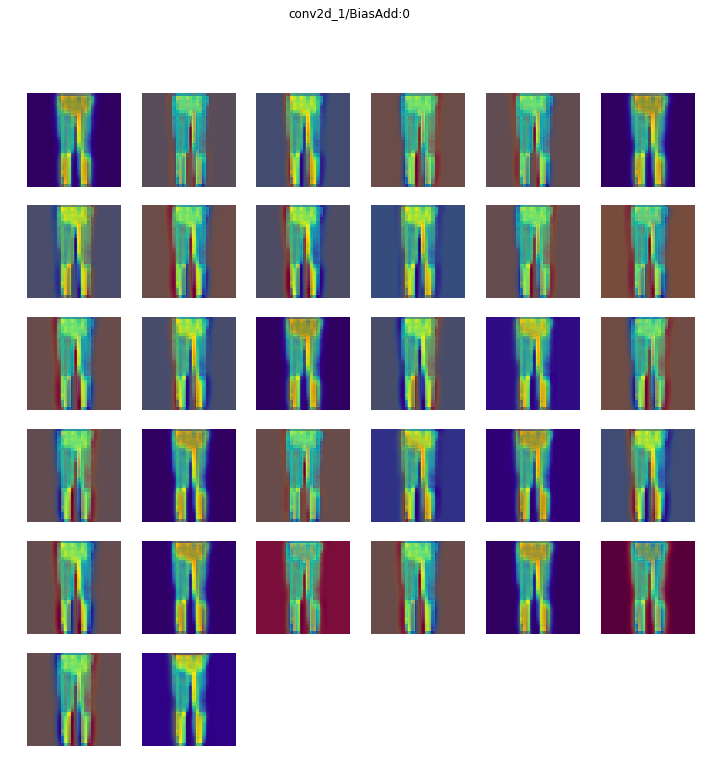

activation_1/Sigmoid:0 (1, 26, 26, 32) 


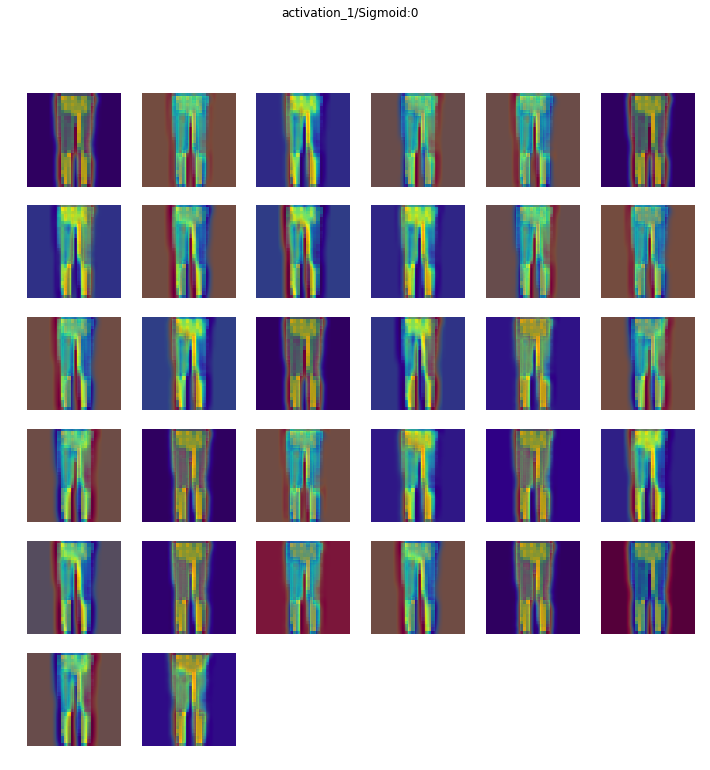

conv2d_2/BiasAdd:0 (1, 24, 24, 64) 


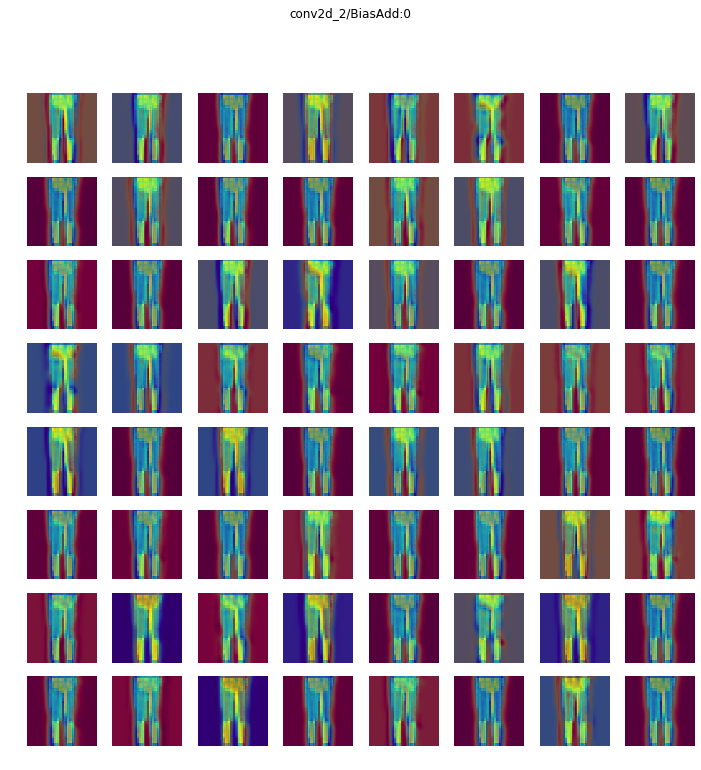

activation_2/Sigmoid:0 (1, 24, 24, 64) 


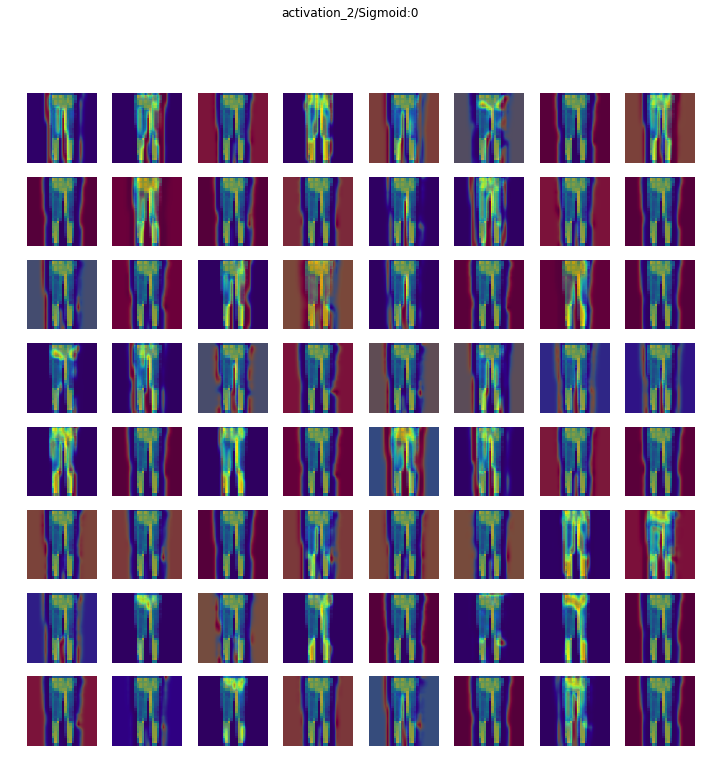

max_pooling2d_1/MaxPool:0 (1, 12, 12, 64) 


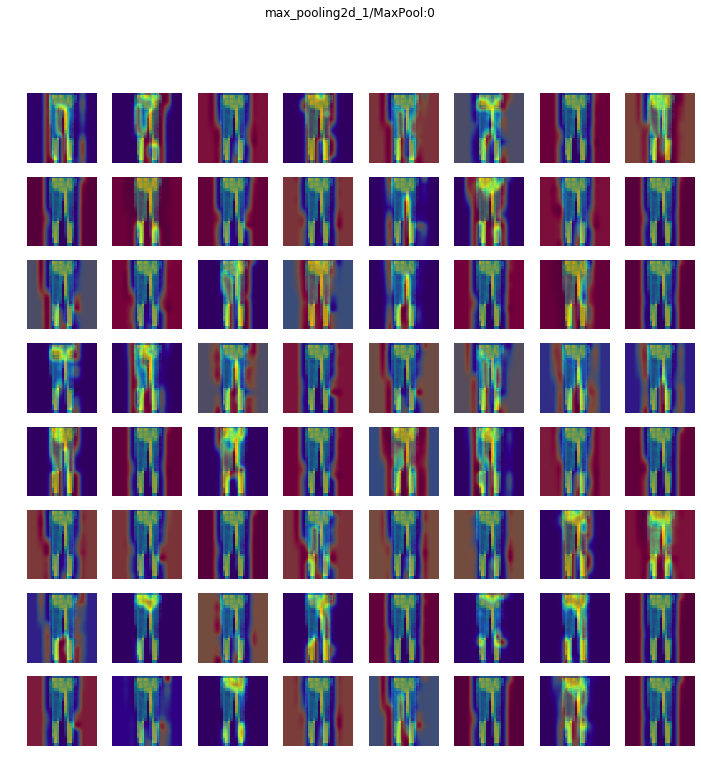

dropout_1/cond/Merge:0 (1, 12, 12, 64) 


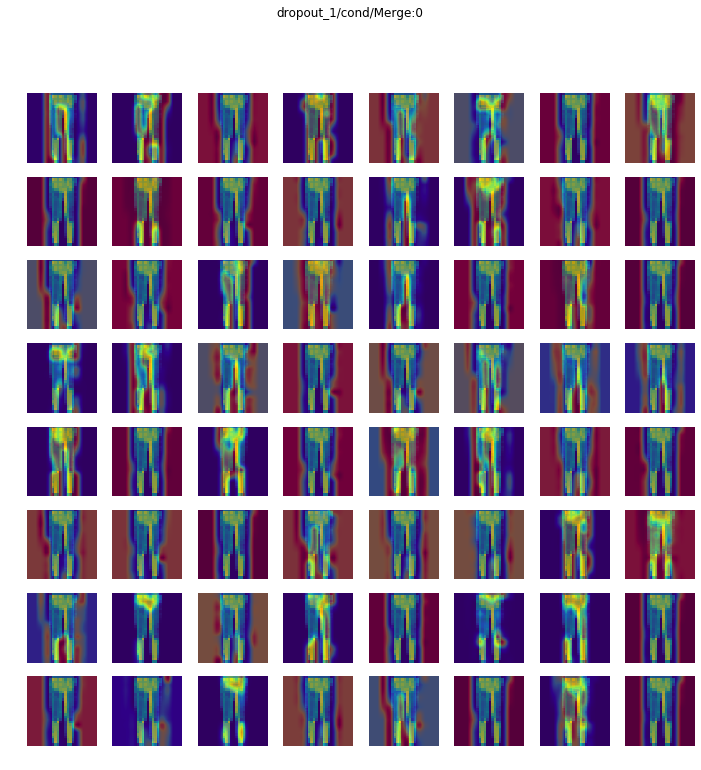

flatten_1/Reshape:0 (1, 9216) -> Skipped. 2D Activations.
dense_1/BiasAdd:0 (1, 128) -> Skipped. 2D Activations.
activation_3/Sigmoid:0 (1, 128) -> Skipped. 2D Activations.
dropout_2/cond/Merge:0 (1, 128) -> Skipped. 2D Activations.
dense_2/BiasAdd:0 (1, 10) -> Skipped. 2D Activations.
activation_4/Softmax:0 (1, 10) -> Skipped. 2D Activations.
conv2d_1/BiasAdd:0
[[[[-0.6529386   0.46445927 -1.0718857  ...  0.5251536   0.2662151
    -0.8912469 ]
   [-0.6529386   0.46445927 -1.0718857  ...  0.5251536   0.2662151
    -0.8912469 ]
   [-0.6529386   0.46445927 -1.0718857  ...  0.5251536   0.2662151
    -0.8912469 ]
   ...
   [-0.6529386   0.46445927 -1.0718857  ...  0.5251536   0.2662151
    -0.8912469 ]
   [-0.6529386   0.46445927 -1.0718857  ...  0.5251536   0.2662151
    -0.8912469 ]
   [-0.6529386   0.46445927 -1.0718857  ...  0.5251536   0.2662151
    -0.8912469 ]]

  [[-0.6529386   0.46445927 -1.0718857  ...  0.5251536   0.2662151
    -0.8912469 ]
   [-0.6529386   0.46445927 -1.0718857

In [24]:
#part 3
import keract
def print_names_and_shapes(activations: dict):
    for layer_name, layer_activations in activations.items():
        print(layer_name)
        print(layer_activations.shape)
        print('')
    print('-' * 80)


def print_names_and_values(activations: dict):
    for layer_name, layer_activations in activations.items():
        print(layer_name)
        print(layer_activations)
        print('')
    print('-' * 80)
a = keract.get_activations(sigmoid_model, x_fashion_test.reshape(x_fashion_test.shape[0],28, 28,1)[3:4])  # with just one sample.
keract.display_heatmaps(a, x_fashion_test[3].reshape(28, 28))
print_names_and_values(a)

In [53]:
b = keract.get_gradients_of_activations(sigmoid_model, x_fashion_test.reshape(x_fashion_test.shape[0],28, 28,1)[0:300], y_fashion_test[0:300])
#print_names_and_values(b)

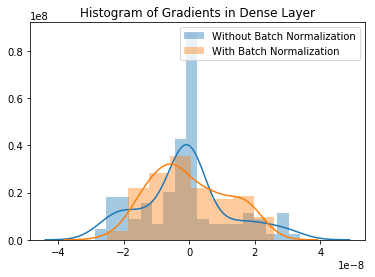

In [54]:
c = keract.get_gradients_of_activations(sigmoid_batch_model, x_fashion_test.reshape(x_fashion_test.shape[0],28, 28,1)[0:300], y_fashion_test[0:300])
#print_names_and_values(b)
c.keys()
sns.distplot(b['activation_3/Sigmoid:0'][0] ,label='Without Batch Normalization');
sns.distplot(c['activation_11/Sigmoid:0'][0],label='With Batch Normalization').set_title('Histogram of Gradients in Dense Layer');
plt.legend()
plt.show()

Answer to question 1:

When training by using sigmoid, we can see that the model starts overfitting at around 91 % accuracy. The validation loss keeps same while training loss keeps decreasing slowly. The validation and training accuracies however don't change much. This is worse than when training with relu because then the accuracy was around 93 % . 

Answer to question 2:

After batch normalization, the performance of the model is similar to as with relu, i.e.  ~ 93 % . This makes sense since the model couldn't learn earlier due to vanishing gradient, but batch normalization keeps optimal operating point for the model to efficiently learn. 

Answer to question 3: In the Histogram plot above, we can see the gradients of activations of the densely connected hidden layer, in the case of without batch normalization, the histogram is 10x more concentrated around 0 , whereas with batch normalization, the histogram has more non zero values and is more spread out. Thus, batch normalization helped keep the gradients non zero to keep the learning process better. 